# Machine Learning Model
## For Predicting Company Success

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import warnings
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
warnings.filterwarnings(action="ignore")

Open files from saved csv

In [2]:
df_full = pd.read_csv('full_features.csv')   # open full feature file
df_only_w_articles = pd.read_csv('joined_list.csv')   # open file with crunchbase articles

In [3]:
np.percentile(df_full[['a_raised_amount']][np.isfinite(df_full['a_raised_amount'])], 50)

4000000.0

In [4]:
np.percentile(df_full[['number_of_tech_crunch_article']][np.isfinite(df_full['number_of_tech_crunch_article'])], 50)

0.0

In [5]:
np.percentile(df_full[['seed_raised_amount']][np.isfinite(df_full['seed_raised_amount'])], 50)

250000.0

In [6]:
np.percentile(df_full[['b_raised_amount']][np.isfinite(df_full['b_raised_amount'])], 50)

9000000.0

In [7]:
np.percentile(df_full[['c_raised_amount']][np.isfinite(df_full['c_raised_amount'])], 1)

965499.99999999988

In [8]:
np.percentile(df_full[['angel_raised_amount']][np.isfinite(df_full['angel_raised_amount'])], 1)

10750.000000000002

In [9]:
class_names = np.array(['No', 'Yes'])

In [10]:
def drop_columns(pd_dataframe, column_list):
    pd_dataframe = pd_dataframe.drop(column_list, 1)
    return pd_dataframe

def handle_nans(pd_dataframe):
    pd_dataframe[['number_of_competitors_got_series_c']] = pd_dataframe[['number_of_competitors_got_series_c']].fillna(value=0)
    pd_dataframe[['number_of_phd']] = pd_dataframe[['number_of_phd']].fillna(value=0)
    pd_dataframe[['number_of_tech_crunch_article']] = pd_dataframe[['number_of_tech_crunch_article']].fillna(value=0)
    pd_dataframe[['seed_raised_amount']] = pd_dataframe[['seed_raised_amount']].fillna(value=0)
    pd_dataframe[['a_raised_amount']] = pd_dataframe[['a_raised_amount']].fillna(value=0)
    pd_dataframe[['b_raised_amount']] = pd_dataframe[['b_raised_amount']].fillna(value=0)
    pd_dataframe[['c_raised_amount']] = pd_dataframe[['c_raised_amount']].fillna(value=0)
    pd_dataframe[['a_months']] = pd_dataframe[['a_months']].fillna(value=0)
    pd_dataframe[['b_months']] = pd_dataframe[['b_months']].fillna(value=0)
    pd_dataframe[['c_months']] = pd_dataframe[['c_months']].fillna(value=0)
    pd_dataframe[['angel_raised_amount']] = pd_dataframe[['angel_raised_amount']].fillna(value=0)
    pd_dataframe[['no_of_employees']] = pd_dataframe[['no_of_employees']].fillna(value=5)
    pd_dataframe['no_of_employees'] = pd_dataframe['no_of_employees'].where(pd_dataframe['no_of_employees'] <= 10001, 10001) 
    pd_dataframe[['label']] = pd_dataframe[['label_stage']].fillna(value=0)
    pd_dataframe['label'][(pd_dataframe.label == 'acquired') |  
                          (pd_dataframe.label== 'post_ipo_equity') | 
                          (pd_dataframe.label== 'c') |
                          (pd_dataframe.label== 'd') |
                          (pd_dataframe.label== 'e') |
                          (pd_dataframe.label== 'f') |
                          (pd_dataframe.label== 'ipo')] = 1
    pd_dataframe['label'][(pd_dataframe.label == 'Dead') |
                         #(pd_dataframe.label== 'c') |
                         #(pd_dataframe.label== 'd') |
                         #(pd_dataframe.label== 'e') |
                         #(pd_dataframe.label== 'f') |
                         (pd_dataframe.label== 'grant') |
                         (pd_dataframe.label== 'debt_round')] = 0
    pd_dataframe = pd_dataframe.drop(['label_stage'], 1)
    
    for col in list(pd_dataframe.columns):
        if col != 'label':
            pd_dataframe[col] = (pd_dataframe[col] - pd_dataframe[col].min())/(pd_dataframe[col].max() - pd_dataframe[col].min())

    
    return pd_dataframe
    
# returns train and test set
# needs pandas dataframe
# 
def prepare_for_ml(pd_dataframe, size_train):
    msk = np.random.rand(len(pd_dataframe)) < size_train
    train = pd_dataframe[msk]
    test = pd_dataframe[~msk]
    
    X_train = train.drop(['label'], 1)
    y_train = train[['label']].label.astype(int)

    X_test = test.drop(['label'], 1)
    y_test = test[['label']].label.astype(int)
    
    return [X_train, y_train, X_test, y_test]

def train_model(model, X_train_in, y_train_in):
    # train model and return
    model.fit(X_train_in, y_train_in)
    return model

def train_model_without_words(model, X_train_in, y_train_in):
    X_train_in = X_train_in.drop(['1', '2', '3', '4', '5', '6', '7', '8', '9'], 1)
    # train model and return
    model.fit(X_train_in, y_train_in)
    return model

def provide_model_performance(t_model, X_test_in, y_test_in):
    y_pred_log = t_model.predict(X_test_in)   
    cm = confusion_matrix(y_test_in, y_pred_log)
    accuracy = (cm[0][0] + cm[1][1]) / len(y_test)
    TPR = cm[1][1] / (cm[1][0] + cm[1][1])
    FPR = cm[0][1] / (cm[0][1] + cm[0][0])
    fpr, tpr, thresholds = roc_curve(y_test_in, y_pred_log)
    roc_auc = auc(fpr, tpr)
    return [accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc]

# this function saves a model to the disk
def save_model(t_model, model_name):
    filename = model_name + '.sav'
    joblib.dump(t_model, filename)
    
# this function loads a saved model    
def load_saved_model(filename):
    return joblib.load(filename + '.sav')

def provide_model_performance_without_words(t_model, X_test_in, y_test_in):
    X_test_in = X_test_in.drop(['1', '2', '3', '4', '5', '6', '7', '8', '9'], 1)
    y_pred_log = t_model.predict(X_test_in)   
    cm = confusion_matrix(y_test_in, y_pred_log)
    accuracy = (cm[0][0] + cm[1][1]) / len(y_test)
    TPR = cm[1][1] / (cm[1][0] + cm[1][1])
    FPR = cm[0][1] / (cm[0][1] + cm[0][0])
    fpr, tpr, thresholds = roc_curve(y_test_in, y_pred_log)
    roc_auc = auc(fpr, tpr)
    return [accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc]

def plot_roc(fpr, tpr):
    plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('FP rate',  fontsize=14, color='black')
    plt.ylabel('TP rate',  fontsize=14, color='black')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('ROC curve',  fontsize=14, color='black')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
    plt.plot(fpr, tpr)
    plt.grid(True)
    return plt

def feature_importance(model_full, X_train_in):
    feature_importance = np.abs(model_full.coef_)
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_importance = feature_importance[0]
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train_in.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.grid(True)
    return plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def feature_importance(model_full, X_train_full):
    feature_importance = np.abs(model_full.coef_)
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_importance = feature_importance[0]
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(10, 10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train_full.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.grid(True)

In [11]:
to_drop = ['label', 
               'number_of_acquisition', 
               'headquarter_location', 
               'number_of_competition',  
               'seed_months', 
               'number_of_engineering_background', 
               'number_of_financial_background', 
               'label_date',  
               #'Unnamed: 0',
               'name', 
               'permalink', 
               '0', 
               'number_of_hacker_news_article', 
               'category', 
               'com_domain', 
               'a_num', 
               'b_num', 
               'c_num', 
               'angel_months', 
               'angel_num', 
               'seed_num']

With topic modeling
Accuracy = 91.83234352977514%
TPR = 74.62774072087672%
FPR = 2.5279189994547795%
ROC = 0.8604991086071097%
[[ 679.9   17.6]
 [  58.3  170.4]]
Without topic modeling
Accuracy = 91.5847828721373%
TPR = 72.8745712519134%
FPR = 2.2288716269881124%
ROC = 0.8532284981246263%
[[ 677.5   15.5]
 [  62.2  166.6]]


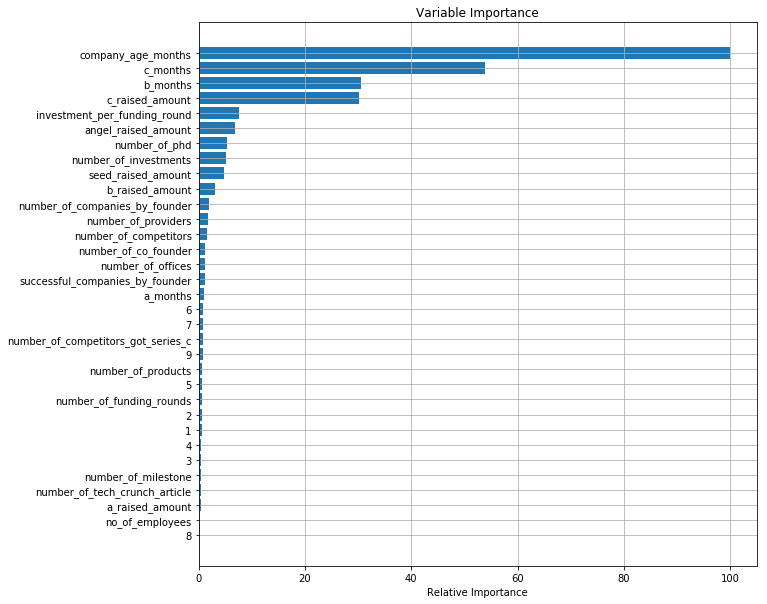

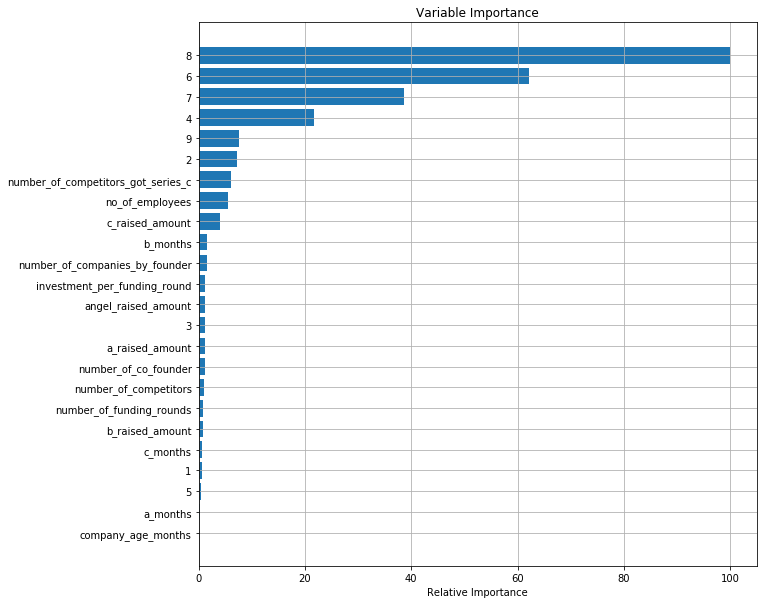

In [12]:
my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_only_w_articles, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)

feature_importance(trained_model, X_train)
#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')


## Work on whole dataset

With topic modeling
Accuracy = 97.24375441895108%
TPR = 70.1273130802799%
FPR = 0.4705175633253608%
ROC = 0.8482839775847728%
[[ 8248.6    39. ]
 [  208.7   490.5]]
Without topic modeling
Accuracy = 97.32475257271093%
TPR = 71.39689171490751%
FPR = 0.4944568636254609%
ROC = 0.8545121742564101%
[[ 8243.9    41. ]
 [  199.3   497.1]]


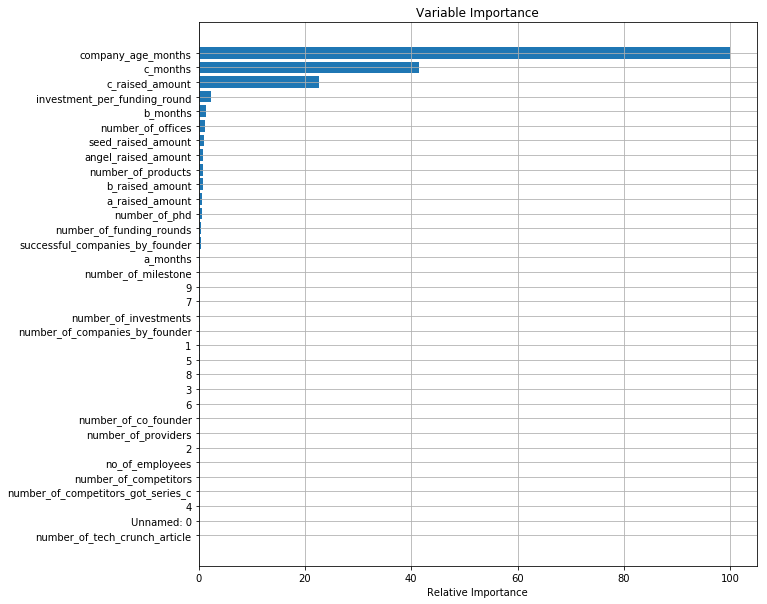

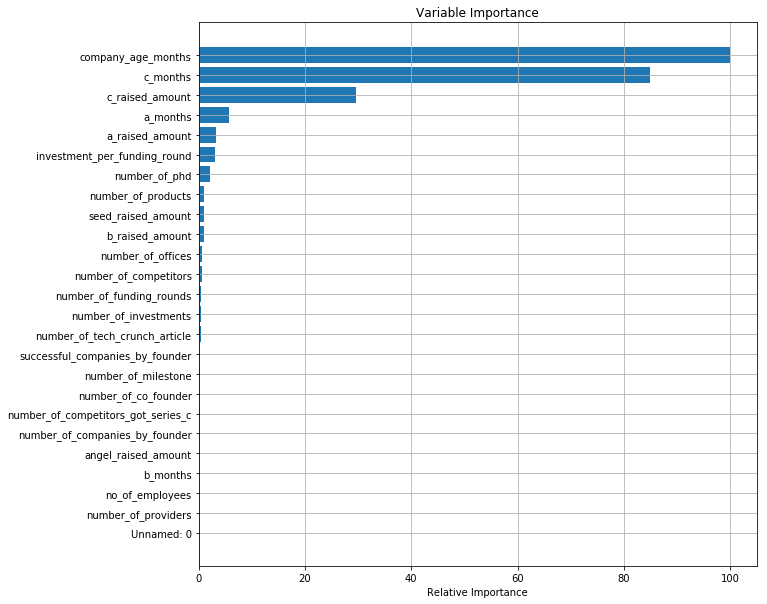

In [13]:
my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full, to_drop)
final_df = handle_nans(final_df)


print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

# PLOT FEATURE IMPORTANCE
feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()
feature_importance(trained_model, X_train)

#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')



## Category Wise Analysis

In [14]:
df_full['category'].unique()

array(['network_hosting', 'enterprise', 'other', 'web', 'games_video',
       'mobile', 'consulting', 'public_relations', 'software', nan,
       'hardware', 'search', 'ecommerce', 'education', 'biotech',
       'advertising', 'semiconductor', 'cleantech', 'security', 'legal'], dtype=object)

### category = 'advertising'

With topic modeling
Accuracy = 98.76897840759129%
TPR = 86.3040153149093%
FPR = 0.4179054760164367%
ROC = 0.9294305491944643%
[[ 492.1    2.1]
 [   4.4   27.4]]
Without topic modeling
Accuracy = 98.7929982819192%
TPR = 87.98025329011435%
FPR = 0.5130227390623371%
ROC = 0.9373361527552602%
[[ 502.3    2.6]
 [   3.9   27.8]]


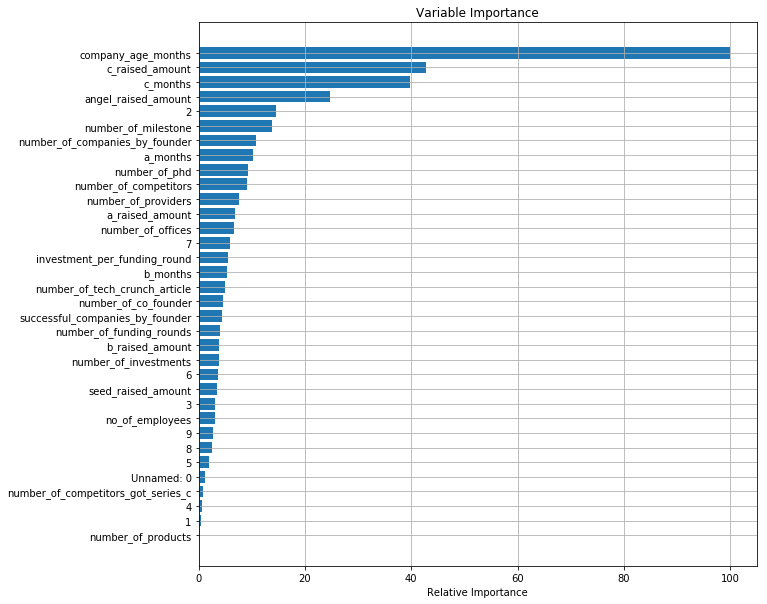

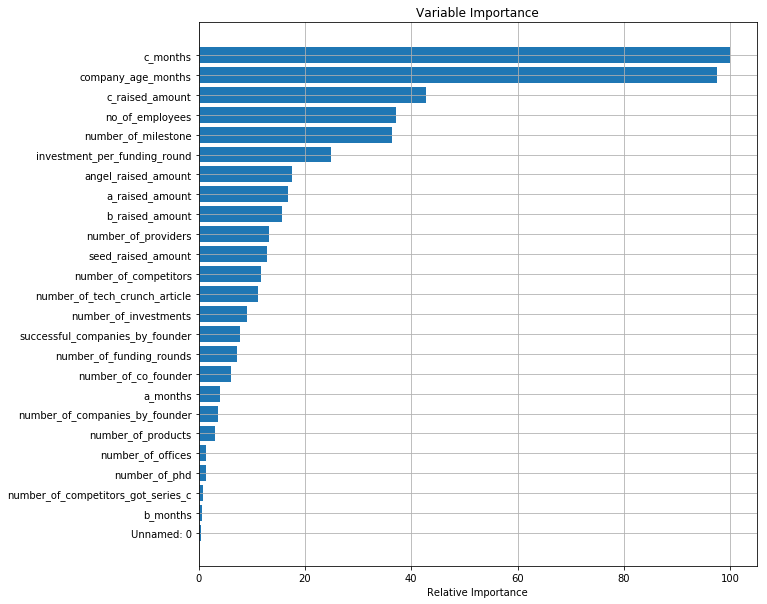

In [15]:
df_full_ad = df_full[df_full.category == 'advertising']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()
feature_importance(trained_model, X_train)

#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'network_hosting'

With topic modeling
Accuracy = 96.65070279204959%
TPR = 76.06679168769834%
FPR = 1.170690821518238%
ROC = 0.8744805043309005%
[[ 202.2    2.4]
 [   5.2   16.6]]
Without topic modeling
Accuracy = 97.59797744149081%
TPR = 85.91695223832122%
FPR = 1.2936577097433701%
ROC = 0.9231164726428892%
[[ 212.5    2.8]
 [   2.9   17.9]]


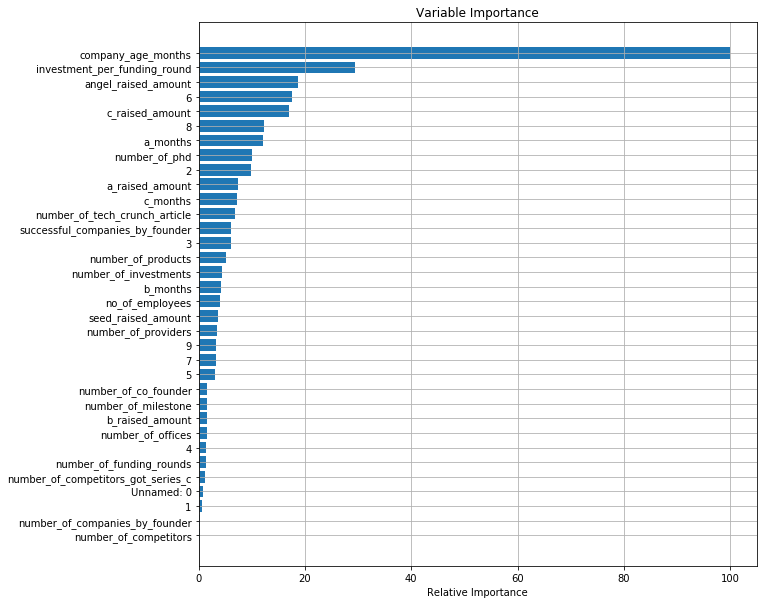

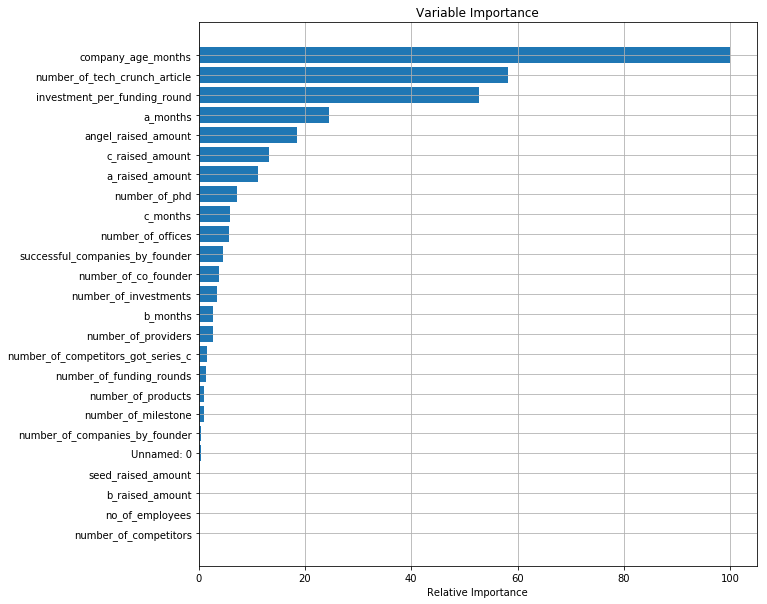

In [16]:
df_full_ad = df_full[df_full.category == 'network_hosting']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()
feature_importance(trained_model, X_train)

#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'web'

With topic modeling
Accuracy = 98.11564388104628%
TPR = 73.54983656817323%
FPR = 0.5366552458824505%
ROC = 0.8650659066114539%
[[ 1538.8     8.3]
 [   22.4    62.6]]
Without topic modeling
Accuracy = 97.91630401389112%
TPR = 69.70590320359035%
FPR = 0.587759519024301%
ROC = 0.8455907184228302%
[[ 1540.9     9.1]
 [   24.9    57.3]]


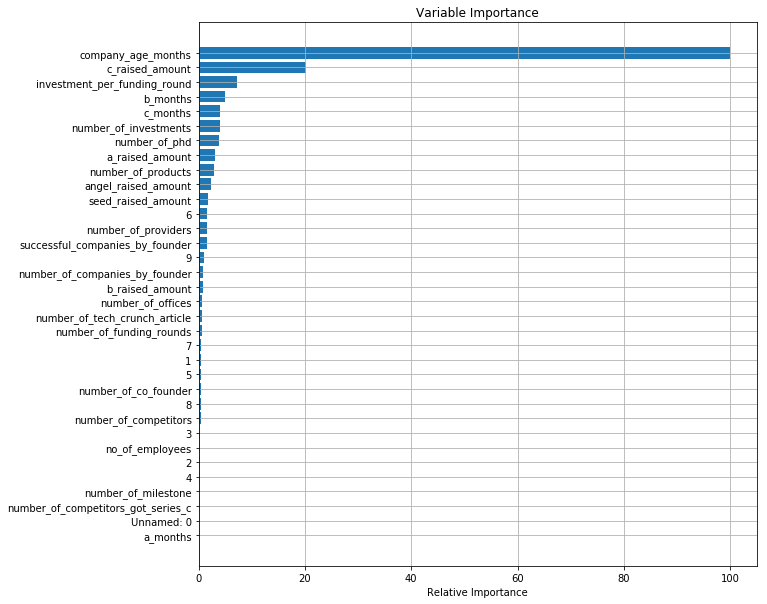

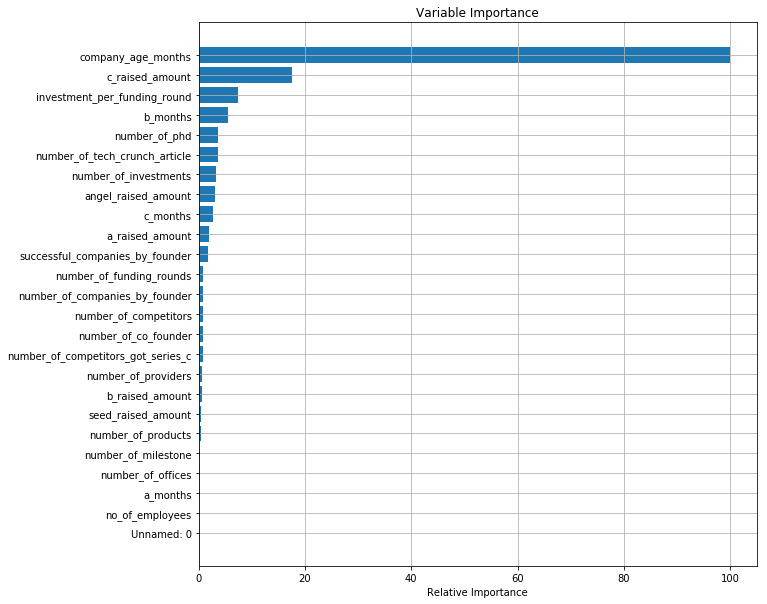

In [17]:
df_full_ad = df_full[df_full.category == 'web']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()
feature_importance(trained_model, X_train)

#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'games_video'

With topic modeling
Accuracy = 97.52297123508818%
TPR = 71.5192779558987%
FPR = 0.6234987565173847%
ROC = 0.8544788959969066%
[[ 469.8    3. ]
 [   9.6   24.5]]
Without topic modeling
Accuracy = 97.37923094327549%
TPR = 66.79872657780301%
FPR = 0.6017871953847804%
ROC = 0.830984696912091%
[[ 463.2    2.8]
 [  10.3   21.8]]


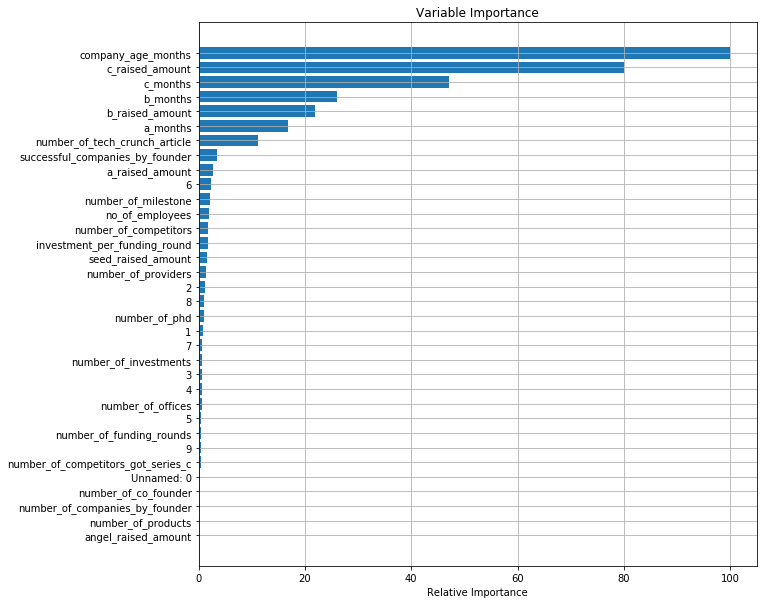

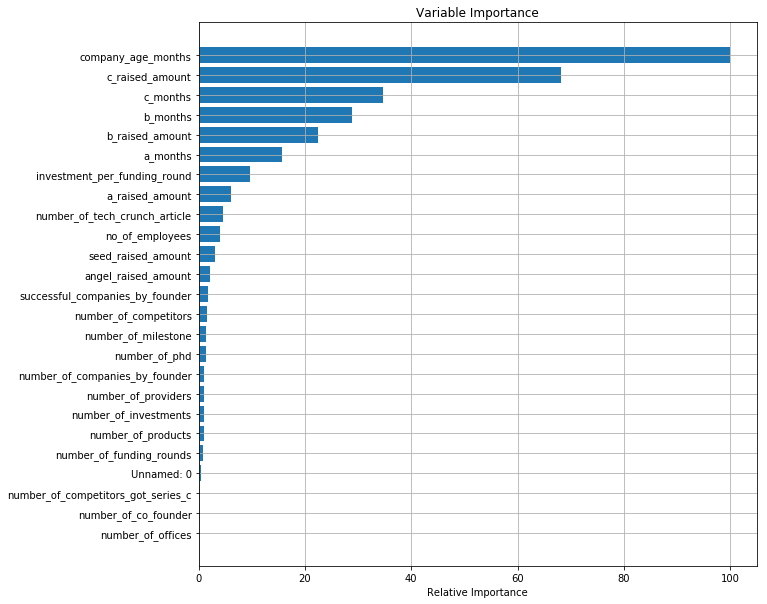

In [18]:
df_full_ad = df_full[df_full.category == 'games_video']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()
feature_importance(trained_model, X_train)

#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'mobile'

With topic modeling
Accuracy = 96.65734546625757%
TPR = 59.83979489393758%
FPR = 0.32071736321284416%
ROC = 0.7975953876536237%
[[ 489.4    1.6]
 [  16.    23.9]]
Without topic modeling
Accuracy = 96.66213059122374%
TPR = 59.98875096329197%
FPR = 0.4673937101687678%
ROC = 0.797606786265616%
[[ 498.3    2.4]
 [  15.6   22.8]]


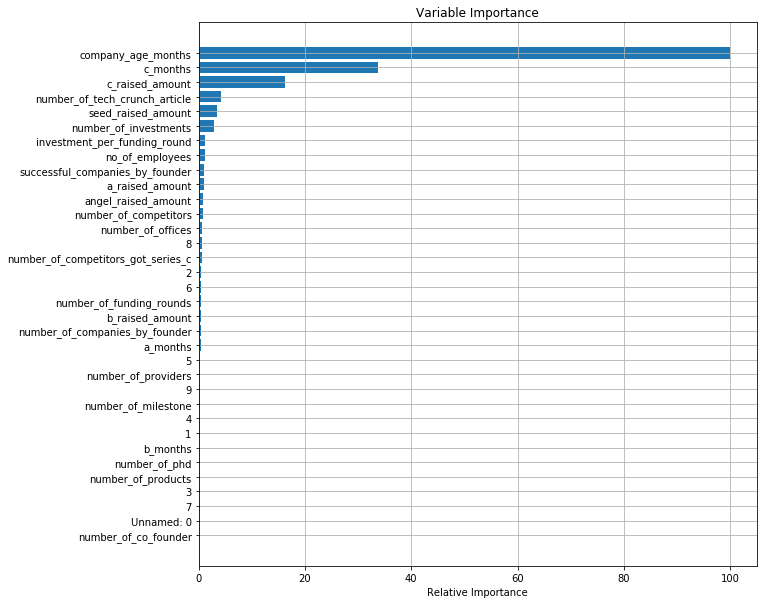

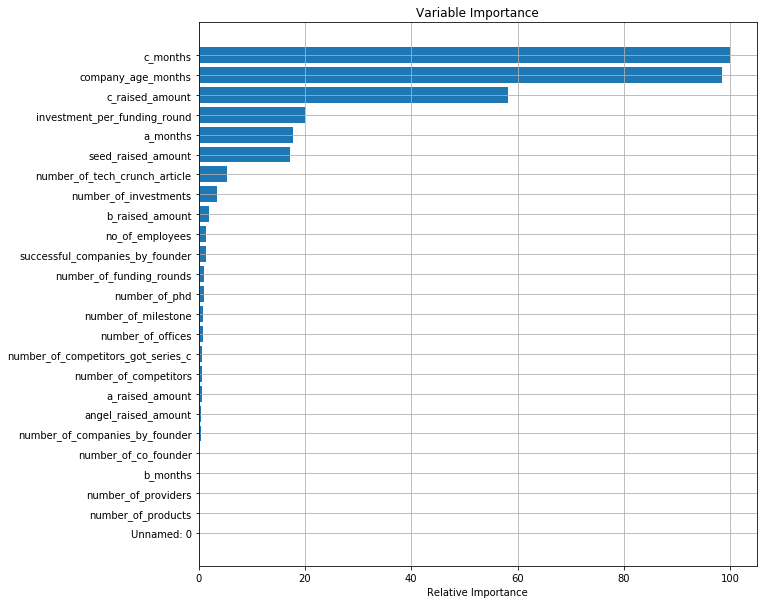

In [19]:
df_full_ad = df_full[df_full.category == 'mobile']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'public_relations'

With topic modeling
Accuracy = 97.45785033573901%
TPR = 76.0371889219648%
FPR = 0.8979194088995442%
ROC = 0.8756963475653263%
[[ 294.     2.7]
 [   5.4   16.3]]
Without topic modeling
Accuracy = 97.88049370155692%
TPR = 81.80929539567984%
FPR = 0.8277033134259951%
ROC = 0.9049079604112691%
[[ 295.8    2.5]
 [   4.3   18.9]]


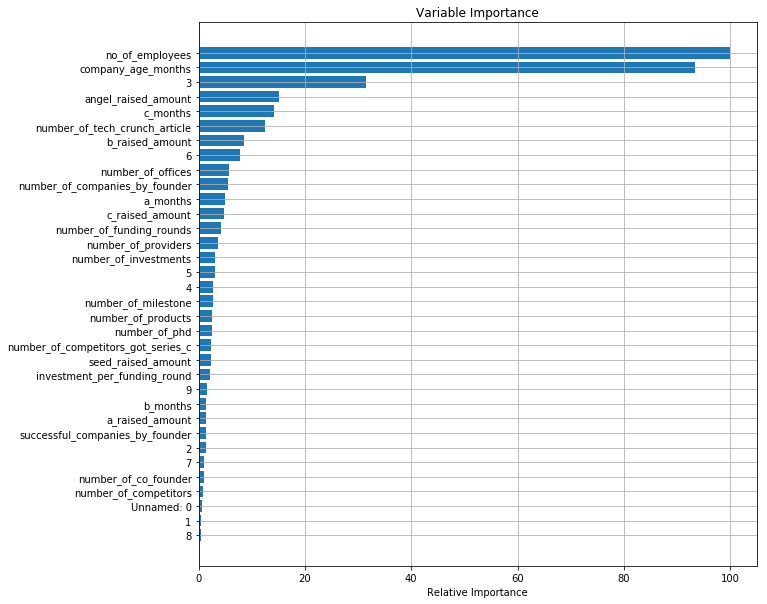

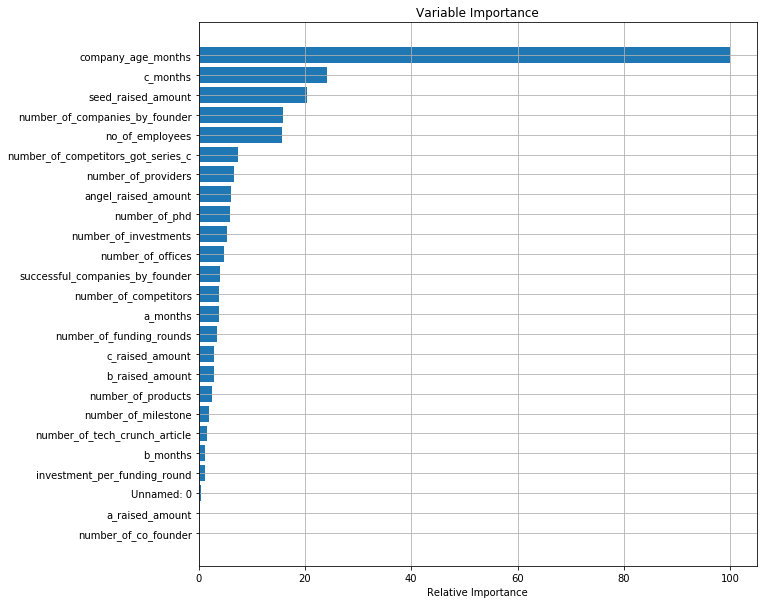

In [20]:
df_full_ad = df_full[df_full.category == 'public_relations']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'software'

With topic modeling
Accuracy = 97.93153299231832%
TPR = 82.93854256473863%
FPR = 0.3951421491133427%
ROC = 0.9127170020781262%
[[ 1414.7     5.6]
 [   27.    130.6]]
Without topic modeling
Accuracy = 97.71062598550145%
TPR = 81.78100192482121%
FPR = 0.5070168376637424%
ROC = 0.9063699254357875%
[[ 1432.8     7.3]
 [   29.3   131.7]]


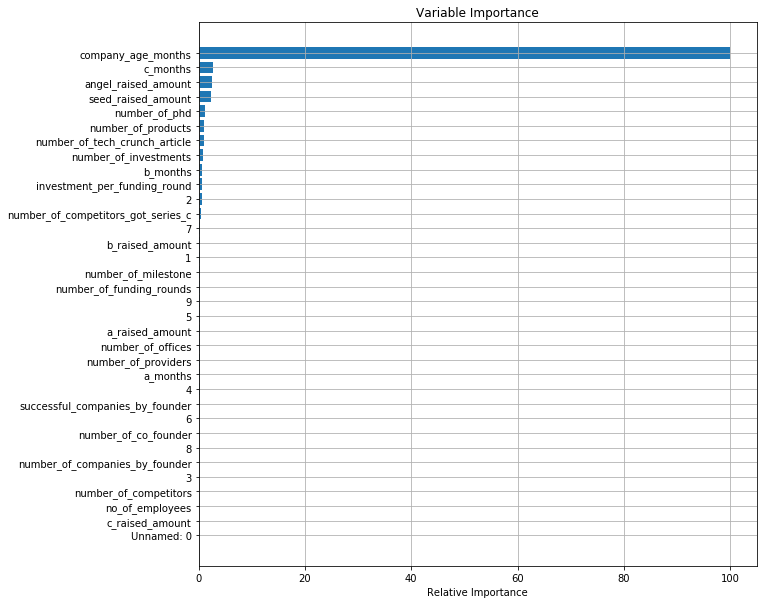

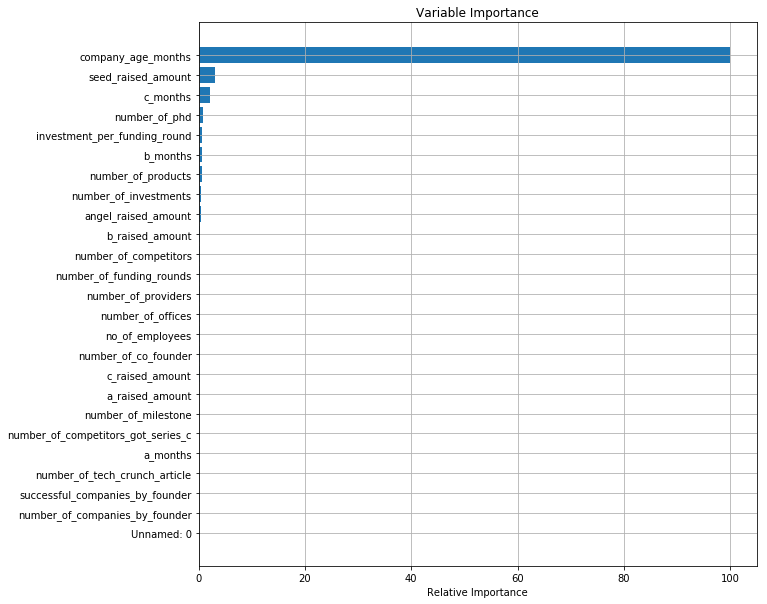

In [21]:
df_full_ad = df_full[df_full.category == 'software']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'hardware'

With topic modeling
Accuracy = 94.28499972498929%
TPR = 74.20842550241666%
FPR = 2.3141115337382385%
ROC = 0.8594715698433923%
[[ 150.4    3.7]
 [   6.7   19.2]]
Without topic modeling
Accuracy = 94.71889098146819%
TPR = 70.98001628001627%
FPR = 1.5504309018646065%
ROC = 0.8471479268907585%
[[ 137.     2.2]
 [   6.4   16. ]]


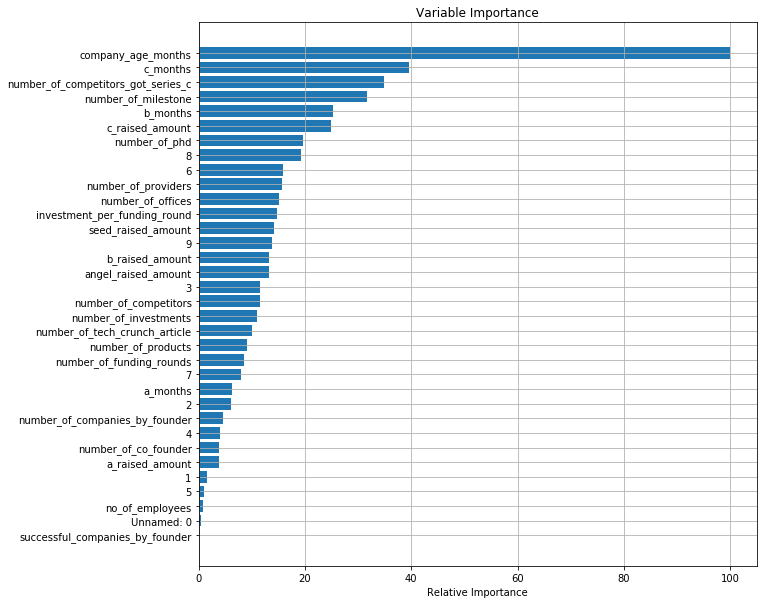

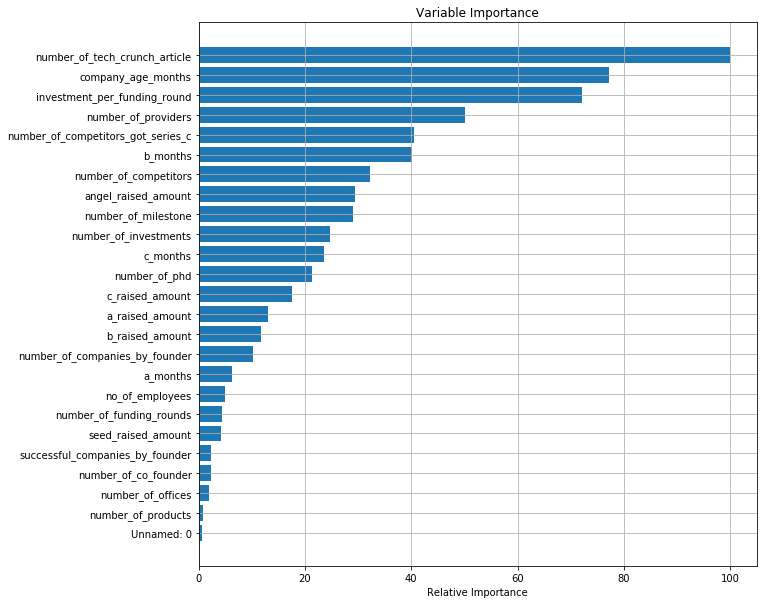

In [22]:
df_full_ad = df_full[df_full.category == 'hardware']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

### category = 'search'

In [23]:
df_full_ad = df_full[df_full.category == 'search']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

With topic modeling
Accuracy = 97.7009299501528%
TPR = 61.85409035409035%
FPR = 0.7811452891370924%
ROC = 0.8053647253247662%
[[ 188.7    1.5]
 [   3.1    4.5]]
Without topic modeling
Accuracy = 98.17112529304562%
TPR = 69.51118326118325%
FPR = 0.6027838333369635%
ROC = 0.8445419971392315%
[[ 181.7    1.1]
 [   2.4    5.4]]


### category = 'ecommerce'

In [24]:
df_full_ad = df_full[df_full.category == 'ecommerce']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

With topic modeling
Accuracy = 98.32755347117039%
TPR = 55.285190597978314%
FPR = 0.31743430655583893%
ROC = 0.7748387814571123%
[[ 726.2    2.3]
 [  10.3   12. ]]
Without topic modeling
Accuracy = 98.13822458722079%
TPR = 54.545367736822016%
FPR = 0.3136077700536108%
ROC = 0.771158799833842%
[[ 704.2    2.2]
 [  11.4   13.4]]


### category = 'enterprise'

In [25]:
df_full_ad = df_full[df_full.category == 'enterprise']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

With topic modeling
Accuracy = 94.74967191501982%
TPR = 65.290264656477%
FPR = 1.0268608391680807%
ROC = 0.8213170190865446%
[[ 265.9    2.8]
 [  13.3   25. ]]
Without topic modeling
Accuracy = 95.57448864190296%
TPR = 71.20373768743333%
FPR = 1.0676611021325302%
ROC = 0.8506803829265042%
[[ 266.3    2.9]
 [  10.6   26.1]]


### category = 'biotech'

### category = 'semiconductor'

### category = 'cleantech'

In [26]:
df_full_ad = df_full[df_full.category == 'cleantech']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()


#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

With topic modeling
Accuracy = 92.52066758226111%
TPR = 64.78647599390634%
FPR = 3.502882737490024%
ROC = 0.8064179662820816%
[[ 103.1    3.7]
 [   5.4    9.3]]
Without topic modeling
Accuracy = 92.38175113442217%
TPR = 61.113949646844404%
FPR = 2.9274456326120504%
ROC = 0.7909325200711617%
[[ 95.7   2.9]
 [  5.8   9.3]]


### category = 'consulting'

With topic modeling
Accuracy = 98.88434177310398%
TPR = 60.56637806637807%
FPR = 0.3632548981974946%
ROC = 0.8010156158409029%
[[ 412.6    1.5]
 [   3.2    5.3]]
Without topic modeling
Accuracy = 99.00882494854427%
TPR = 79.13133435192259%
FPR = 0.4116640169773009%
ROC = 0.8935983516747263%
[[ 411.1    1.7]
 [   2.5    7.4]]


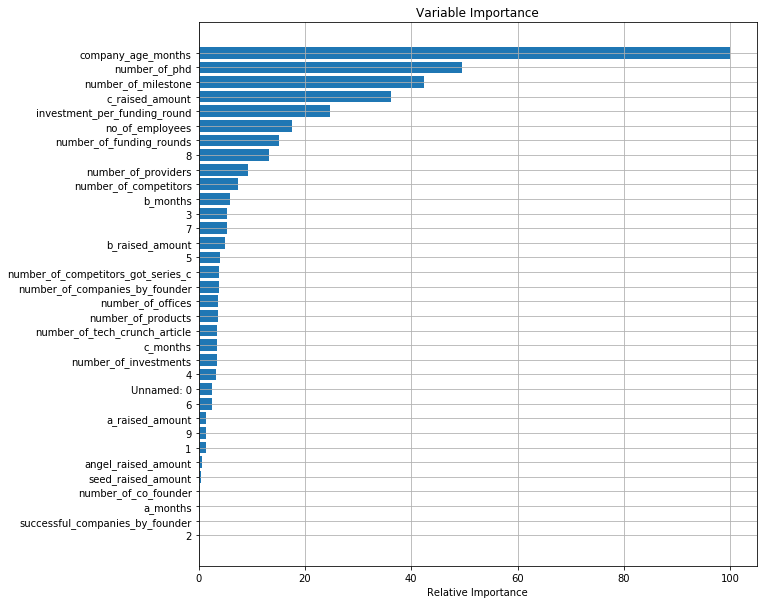

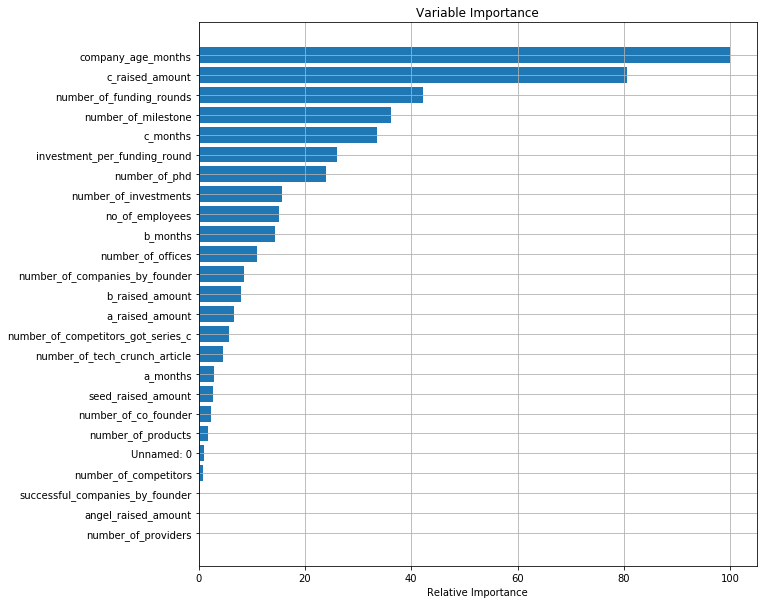

In [32]:
df_full_ad = df_full[df_full.category == 'consulting']

my_model = LogisticRegressionCV(10, random_state=1)
final_df = drop_columns(df_full_ad, to_drop)
final_df = handle_nans(final_df)

print('With topic modeling')
exp_size = 10
accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()

feature_importance(trained_model, X_train)
#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

print('Without topic modeling')

accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size, [0]*exp_size
for i in range(exp_size):
    
    X_train, y_train, X_test, y_test = prepare_for_ml(final_df, .8)
    trained_model = train_model_without_words(my_model, X_train, y_train)
    accuracy[i], cm[i], TPR[i], FPR[i], fpr[i], tpr[i], thresholds[i], roc_auc[i] = provide_model_performance_without_words(trained_model, X_test, y_test)
    
    
print('Accuracy = {}%'.format(np.mean(accuracy)*100))
print('TPR = {}%'.format(np.mean(TPR)*100))
print('FPR = {}%'.format(np.mean(FPR)*100))
print('ROC = {}%'.format(np.mean(roc_auc)))
cm_print = np.mean(cm, axis=0)
print(cm_print)


#plot_roc(np.mean(fpr, axis=0), np.mean(tpr, axis=0)).show()
feature_importance(trained_model, X_train)

#plot_confusion_matrix(cm_print, classes=class_names, normalize=True, title='Normalized confusion matrix')

## testing saved model

In [28]:
save_model(trained_model, 'model_cat_network_hosting')

In [29]:
#loaded_model = load_saved_model('model_cat_network_hosting')

In [30]:
#accuracy, cm, TPR, FPR, fpr, tpr, thresholds, roc_auc = provide_model_performance(loaded_model, X_test, y_test)

In [31]:
#print('Accuracy = {}%'.format(accuracy*100))
#print('TPR = {}%'.format(TPR*100))
#print('FPR = {}%'.format(FPR*100))
#print(cm)